In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import ase
import ase.io
from ase.data import atomic_masses
from chemiscope import write_input
import plumed 

# Exercise 1

This is the code from the exercise to generate the graph of the torsion as a function of time.

In [2]:
# Read in trajectory using ase
traj = ase.io.read('../data/traj.pdb',':')

# Setup plumed object to do calculation
p = plumed.Plumed()
p.cmd("setMDEngine","python")
p.cmd("setTimestep", 1.)
p.cmd("setKbT", 1.)
natoms = len(traj[0].positions)
p.cmd("setNatoms",natoms)
p.cmd("setLogFile","test.log")
p.cmd("init")

# Read plumed input 
p.cmd("readInputLine","MOLINFO STRUCTURE=../data/bhp.pdb")
p.cmd("readInputLine", "t1: TORSION ATOMS=@phi-2" )
# Get the shape of the value calculated in plumed
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank t1 ", shape )
# Now setup some memory to hold the variable that is shared 
# between plumed and the underlying code
t1 = np.zeros((1))
p.cmd("setMemoryForData t1", t1 )

# Loop over trajectory and get data from plumed
nfram, tt, v1, box = 0, [], [], np.array([[100.,0,0],[0,100.,0],[0,0,100]])
charges, forces, virial = np.zeros(natoms,dtype=np.float64), np.zeros([natoms,3]), np.zeros((3,3),dtype=np.float64)
for ts in traj :
    p.cmd("setStep",nfram)
    p.cmd("setBox",box )
    p.cmd("setMasses", ts.get_masses() )
    p.cmd("setCharges", charges )
    pos = np.array(ts.get_positions(), dtype=np.float64 )
    p.cmd("setPositions", pos )
    p.cmd("setForces", forces )
    p.cmd("setVirial", virial )
    p.cmd("calc")
    tt.append(nfram)
    v1.append(t1[0])
    nfram = nfram + 1

I have just separated out the part to draw the graph from the data above.  This code is in the cell below:

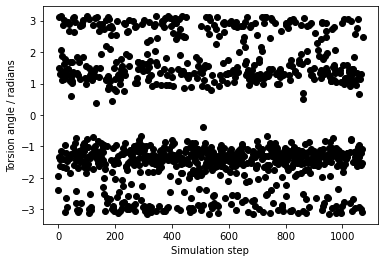

In [4]:
plt.plot( tt, v1, 'ko')
plt.xlabel("Simulation step")
plt.ylabel("Torsion angle / radians")
plt.savefig("masterclass-21-6-phi-time.png")

And here is the modified code to do what you were asked to do.  This code is using plumed to calculate $\phi_2$ and $\psi_2$ and is then drawing a graph with the first of these two quantities on the x axis and the second on the y-axis.

In [4]:
# Read in trajectory using ase
traj = ase.io.read('../data/traj.pdb',':')

# Setup plumed object to do calculation
p = plumed.Plumed()
p.cmd("setMDEngine","python")
p.cmd("setTimestep", 1.)
p.cmd("setKbT", 1.)
natoms = len(traj[0].positions)
p.cmd("setNatoms",natoms)
p.cmd("setLogFile","test.log")
p.cmd("init")

# Read plumed input 
p.cmd("readInputLine","MOLINFO STRUCTURE=../data/bhp.pdb")
# Setup the calculation of the first torsion
p.cmd("readInputLine", "t1: TORSION ATOMS=@phi-2" )
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank t1 ", shape )
t1 = np.zeros((1))
p.cmd("setMemoryForData t1", t1 )
# Setup the calculation of the second torsion
p.cmd("readInputLine", "t2: TORSION ATOMS=@psi-2" )
p.cmd("getDataRank t2 ", shape )
t2 = np.zeros((1))
p.cmd("setMemoryForData t2", t2 )

# Loop over trajectory and get data from plumed
nfram, v2, v3, box = 0, [], [], np.array([[100.,0,0],[0,100.,0],[0,0,100]])
charges, forces, virial = np.zeros(natoms,dtype=np.float64), np.zeros([natoms,3]), np.zeros((3,3),dtype=np.float64)
for ts in traj :
    p.cmd("setStep",nfram)
    p.cmd("setBox",box )
    p.cmd("setMasses", ts.get_masses() )
    p.cmd("setCharges", charges )
    pos = np.array(ts.get_positions(), dtype=np.float64 )
    p.cmd("setPositions", pos )
    p.cmd("setForces", forces )
    p.cmd("setVirial", virial )
    p.cmd("calc")
    v2.append(t1[0])
    v3.append(t2[0])
    nfram = nfram + 1

I have again separated the cell that draws the graph from the cell that generates the data to plot

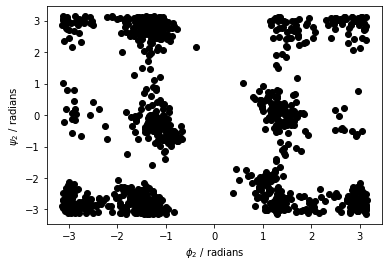

In [5]:
plt.plot( v2, v3, 'ko')
plt.xlabel(r"$\phi_2$ / radians")
plt.ylabel(r"$\psi_2$ / radians")
plt.show()

# Exercise 2

The following cell generates the chemiscope representation that is shown in the text of the exercise

In [6]:
# This ensures that the atomic masses are used in place of the symbols
# when constructing the chemiscope respresentations of the atomic configurations.
# Using the symbols will not work because ase is written by chemists and not 
# biologists.  For a chemist HG1 is mercury as opposed to the first hydrogen
# on a guanine residue.  
for frame in traj:
    frame.numbers = np.array(
        [
            np.argmin(np.subtract(atomic_masses, float(am)) ** 2)
            for am in frame.arrays["occupancy"]
        ]
    )

# This constructs the dicitionary of properties for chemiscope
properties = {
    "time": {
        "target": "structure",
        "values": tt,
        "description": "Simulation step number",
    },
    "t2": {
        "target": "structure",
        "values": v1,
        "description": "Phi angle of second residue",
    },
}

# This generates our chemiscope output
write_input("torsion_chemiscope.json.gz", frames=traj, properties=properties )

This next cell uses plumed to calculate all the backbone torsional angles.

In [7]:
def create_plumed_var( p, name, command ):
    p.cmd("readInputLine", name + ": " + command )
    shape = np.zeros( 1, dtype=np.int_ )
    p.cmd("getDataRank " + name, shape )
    data = np.zeros((1))
    p.cmd("setMemoryForData " + name, data )
    return data

# Read in trajectory using ase
traj = ase.io.read('../data/traj.pdb',':')

# Setup plumed object to do calculation
p = plumed.Plumed()
p.cmd("setMDEngine","python")
p.cmd("setTimestep", 1.)
p.cmd("setKbT", 1.)
natoms = len(traj[0].positions)
p.cmd("setNatoms",natoms)
p.cmd("setLogFile","test.log")
p.cmd("init")

# Read plumed input 
p.cmd("readInputLine","MOLINFO STRUCTURE=../data/bhp.pdb")
torsion_values = []
for i in range(2,17) : 
    torsion_values.append( create_plumed_var(p, "t" + str(i) + "-phi", "TORSION ATOMS=@phi-" + str(i)))
    torsion_values.append( create_plumed_var(p, "t" + str(i) + "-psi", "TORSION ATOMS=@psi-" + str(i)))
     
# Loop over trajectory and get data from plumed
data = []
for i in range(30) : data.append([])
nfram, box = 0, np.array([[100.,0,0],[0,100.,0],[0,0,100]])
charges, forces, virial = np.zeros(natoms,dtype=np.float64), np.zeros([natoms,3]), np.zeros((3,3),dtype=np.float64)
for ts in traj :
    p.cmd("setStep",nfram)
    p.cmd("setBox",box )
    p.cmd("setMasses", ts.get_masses() )
    p.cmd("setCharges", charges )
    pos = np.array(ts.get_positions(), dtype=np.float64 )
    p.cmd("setPositions", pos )
    p.cmd("setForces", forces )
    p.cmd("setVirial", virial )
    p.cmd("calc") 
    for i in range(30) : data[i].append(torsion_values[i][0])
    nfram = nfram + 1

We can thus output them in a chemiscope by using the commands below:

In [8]:
# This ensures that the atomic masses are used in place of the symbols
# when constructing the chemiscope respresentations of the atomic configurations.
# Using the symbols will not work because ase is written by chemists and not 
# biologists.  For a chemist HG1 is mercury as opposed to the first hydrogen
# on a guanine residue.  
for frame in traj:
    frame.numbers = np.array(
        [
            np.argmin(np.subtract(atomic_masses, float(am)) ** 2)
            for am in frame.arrays["occupancy"]
        ]
    )

# This constructs the dicitionary of properties for chemiscope
properties = {}
for i in range(2,17) : 
    k=2*(i-2)
    properties["phi-" + str(i)] = { 
        "target": "structure", 
        "values": data[k], 
        "description": "Phi angle of residue number " + str(k),
    }
    k=2*(i-2) + 1
    properties["psi-" + str(i)] = { 
        "target": "structure", 
        "values": data[k], 
        "description": "Psi angle of residue number " + str(k),
    }

# This generates our chemiscope output
write_input("torsion_chemiscope.json.gz", frames=traj, properties=properties )